<a href="https://colab.research.google.com/github/Nonna-nna/Nonna-nna/blob/Machine-learning/ML_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#参考ソース

https://www.hellocybernetics.tech/entry/2018/06/27/211621#%E3%81%AF%E3%81%98%E3%82%81%E3%81%AB

#各種インポート

In [18]:
tf.executing_eagerly()

True

In [19]:
import numpy as np
import tensorflow as tf
#import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
import seaborn as sns
#tf.enable_eager_execution()

#問題設定

y=x3+2x2−4x−1+2ϵ の関係があるのだが、yを観測するときに平均0分散1のガウスノイズϵが乗って更にノイズが２倍になってしまっているようなケースを想定していることになります。

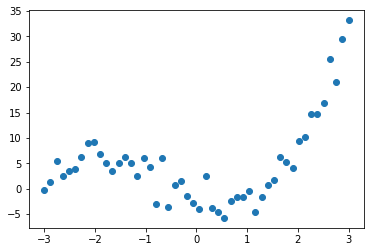

In [20]:
def toy_polynomial_data():
  x = np.linspace(-3, 3, 50)
  y = x**3 + 2*x**2 - 4*x + 2*np.random.randn(50) - 1
  return x, y

x, y = toy_polynomial_data()
plt.scatter(x, y)
plt.show()

#モデルの設計と損失関数

基本的に、tf.keras.Modelクラスを継承して使うことになります。 実際には今回の問題はかなり原始的な話題なので、このクラスを使わなくてもいいのですが、 基本的な雛形はこのような形式になるのではないかと思われるので、慣習に習っておきます。





まず、def __init__(self)には今回のモデルで用いるパラメータ（やニューラルネットワークの層）を準備しておきます。今回必要はa1x1+a2x2+a3x3+bを表すために a1,a2,a3,b 4つのパラメータを準備しておきます。tf.contrib.eager.Variable()を利用し、初期値initial_valueを適当に設定しておきます（乱数を使ってもいいですが、今回は敢えて、答えの数値と明らかに違う数値にしておきます）。

次に、call()メソッドは、モデルの実際の計算を書き下します。今回はa1x1+a2x2+a3x3+bを計算するようにしておくだけなので簡単です。

パラメータの更新は、微分を計算して、現在の値から引くという操作でしたね。これを実行するには勾配（微分）の計算が必要になります。TensorFlowなどの深層学習フレームワークには、指定したパラメータによる微分を自動で計算してくれる仕組みが備わっています。その理論的な背景は「バックプロパゲーション」と呼ばれています。

In [21]:
class Model(tf.keras.Model):

  #今回のモデルで用いるパラメータ（やニューラルネットワークの層）を準備しておきます。
  def __init__(self):
    super(Model, self).__init__()
    '''
    self.a1 = tf.contrib.eager.Variable(dtype=tf.float32,
                                       initial_value=1)
    self.a2 = tf.contrib.eager.Variable(dtype=tf.float32,
                                       initial_value=-1)
    self.a3 = tf.contrib.eager.Variable(dtype=tf.float32,
                                       initial_value=1)
    self.b = tf.contrib.eager.Variable(dtype=tf.float32,
                                       initial_value=2)
                                       '''
    self.a1 = tf.Variable(dtype=tf.float32,
                                       initial_value=1)
    self.a2 = tf.Variable(dtype=tf.float32,
                                       initial_value=-1)
    self.a3 = tf.Variable(dtype=tf.float32,
                                       initial_value=1)
    self.b = tf.Variable(dtype=tf.float32,
                                       initial_value=2)
    
  #モデルの実際の計算を書き下します。
  def call(self, x):
    return self.b + self.a1*x + self.a2*x**2 + self.a3*x**3
  
  #損失関数
  def loss_fn(self, x, y):
    y_pre = self(x)
    mse = 0.5 * (y - y_pre) ** 2 
    return tf.reduce_sum(mse)
  
  #勾配の計算
  def grads_fn(self, x, y):
    with tf.GradientTape() as tape:
      loss = self.loss_fn(x, y)
      return tape.gradient(loss, [self.a1,
                                  self.a2,
                                  self.a3,
                                  self.b])
  #パラメータの更新
  def update(self, x, y, lr=0.001):
    grads = self.grads_fn(x, y)
    ## variable.assign_sub(value)
    ## variable -= value
    self.a1.assign_sub(lr * grads[0])
    self.a2.assign_sub(lr * grads[1])
    self.a3.assign_sub(lr * grads[2])
    self.b.assign_sub(lr * grads[3])

#初期状態のモデルで実験

早速作ったモデルをmodel=Model()でインスタンス化して、実験してみましょう。 まずは学習を全く行わずにデータをぶち込んでみます。

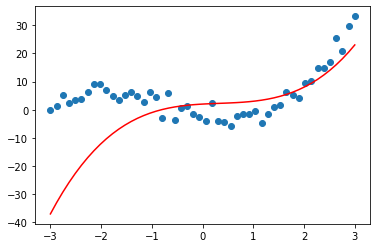

In [25]:
model = Model()
y_init = model(x)

plt.scatter(x, y)
plt.plot(x, y_init, c='r')
plt.show()

#学習後のモデル

400回ほどパラメータの更新を行ってみましょう。 損失の変化を記録するためにloss=[]と、モデルの予測の記録を取るためにreg=[]を準備しておきます。

あとはfor文の中でmodel.update(x, y)により学習を進めます。(y_pre=model(x)は予測の記録を取るためだけのコードです)

In [26]:
reg = []
loss = []
for _ in range(400):
    y_pre = model(x)
    reg.append((x, y_pre))
    model.update(x, y, 2e-4)
    loss.append(model.loss_fn(x, y))

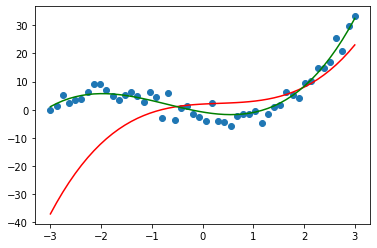

In [28]:
model = Model()
y_init = model(x)

plt.scatter(x, y)
plt.plot(x, y_init, c='r')
plt.plot(x, y_pre, c='g')
plt.show()

#本当に学習は上手く行ったのか

損失の変化に関しては以下のようになっており、ほとんど収束しているように見えます。

しかし、これだけでは学習が上手く行ったのかは本当はわかりません。 同様のデータをもう１セット準備しておいて、テストをする必要があります。 今回の手法は、手持ちのデータに対して損失関数を最小化するに過ぎません。

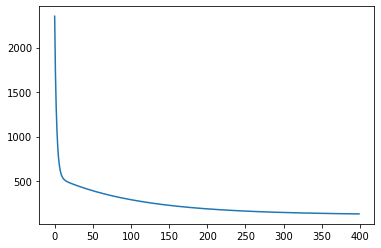

In [24]:
plt.plot(range(400), loss)
plt.show()

#課題

検証用データがない

推定でどんな多項式が導かれたのかわからない